# 0. Problem statement

As a **portfolio analyst**, I am interested in automating a way to analyse my portfolio of longer-term investments and evaluate how the addition of a new security would be expected to impact the portfolio's risk v return. 

# I. Imports

In [1]:
cd ../

/home/murali/personal_projects/stock-price-forecasts


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pandas_datareader.data as reader
import datetime as dt
from datetime import timedelta
from typing import Iterable, Union
import itertools
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from plotly import express as px
import logging
import scipy

In [3]:
import yfinance as yf

In [4]:
from src.utils import get_10y_treasury_yield_data, calculate_beta

# II. Setup

In [5]:
common_path = "eda/data/"
index_ticker = "^GSPC"
period = "1y"
ann_std_multiplier = np.sqrt(252)

In [6]:
current_portfolio = pd.read_csv(common_path + "portfolio_composition.csv")

In [7]:
current_portfolio.head()

ticker purchase_date  frac_of_portfolio
0   AAPL    2021-11-01                0.4
1   GOOG    2021-09-01                0.1
2   MSFT    2021-10-10                0.5

In [8]:
df = yf.Ticker(index_ticker).history(period=period)["Close"].reset_index().rename(columns={"Date": "date", "Close": "sp500_close"})
df["sp500_daily_returns"] = np.log(df["sp500_close"]/df["sp500_close"].shift())

In [9]:
def calculate_expected_returns(df: pd.DataFrame, stock_to_beta: pd.DataFrame, ten_yr_yield: pd.DataFrame, index_name: str) -> pd.DataFrame:
    beta = stock_to_beta.loc[ticker]["beta"]
    rf = ten_yr_yield["yield"]/365
    rm = df.set_index("date")[f"{index_name}_daily_returns"]
    er = rf + beta*(rm - rf)
    
    return er.rename(f"{ticker}_exp_daily_return")

In [10]:
def compute_portfolio_return(ticker_to_weight: dict, df: pd.DataFrame) -> float:
    portfolio_return = 0
    for ticker in ticker_to_weight.keys():
        w = ticker_to_weight[ticker]
        time_weighted_er_ticker = np.product(1+df[f"{ticker}_exp_daily_return"]) - 1
        portfolio_return += w*time_weighted_er_ticker
    
    return portfolio_return

In [11]:
def compute_portfolio_variance(ticker_to_weight: dict, df: pd.DataFrame) -> float:
    portfolio_var = 0
    
    for combo in itertools.combinations_with_replacement(ticker_to_weight.keys(), 2):
        i = combo[0]
        j = combo[1]
        w_i = ticker_to_weight[i]
        w_j = ticker_to_weight[j]
        cov_ij = np.cov(df[f"{i}_exp_daily_return"], df[f"{j}_exp_daily_return"])[0,1]
        
        portfolio_var += w_i*w_j*cov_ij
    
    return portfolio_var

# III. Efficient frontier of current portfolio

In [12]:
ticker_list = list(current_portfolio.ticker)

for ticker in ticker_list:
    t = yf.Ticker(ticker)
    ticker_df = pd.DataFrame(t.history(period=period)["Close"].rename(f"{ticker}_close"))
    ticker_df[f"{ticker}_daily_returns"] = np.log(ticker_df/ticker_df.shift())
    df = df.join(ticker_df, on="date")

df = df.dropna()

In [13]:
stock_to_beta = {"ticker": [], "beta": []}
sp500_returns = df["sp500_daily_returns"]

for ticker in ticker_list:
    stock_to_beta["beta"] += [calculate_beta(df[f"{ticker}_daily_returns"], sp500_returns)]
    stock_to_beta["ticker"] += [ticker]

stock_to_beta = pd.DataFrame(stock_to_beta).set_index("ticker")

In [14]:
er_list = []
ten_yr_yield = get_10y_treasury_yield_data(df, common_path+"10-year-treasury-yield.csv")

for ticker in ticker_list:
    er_ticker = calculate_expected_returns(df, stock_to_beta, ten_yr_yield, "sp500")
    er_list += [er_ticker]

df = df.join(pd.concat(er_list, axis=1), on="date")

In [15]:
possible_weights = []
increment = 0.02

for weights in itertools.combinations_with_replacement(np.arange(0,1+increment,increment), len(ticker_list)):
    if sum(weights) == 1:
        possible_weights += [weights]

In [16]:
final_weights = []

for weights in possible_weights:
    for w in itertools.permutations(weights):
        final_weights += [w]

In [17]:
portfolio_returns = []
portfolio_sd = []
ticker_weights = []

for weights in final_weights:
    ticker_to_weight = dict(zip(ticker_list, weights))
    
    portfolio_returns += [compute_portfolio_return(ticker_to_weight, df)]
    portfolio_sd += [ann_std_multiplier*np.sqrt(compute_portfolio_variance(ticker_to_weight, df))]
    ticker_weights += [weights]

In [18]:
curr_portfolio_weights = current_portfolio[["ticker", "frac_of_portfolio"]].set_index("ticker").to_dict()["frac_of_portfolio"]

curr_portfolio_return = compute_portfolio_return(curr_portfolio_weights, df)
curr_portfolio_stdev = ann_std_multiplier*np.sqrt(compute_portfolio_variance(curr_portfolio_weights, df))

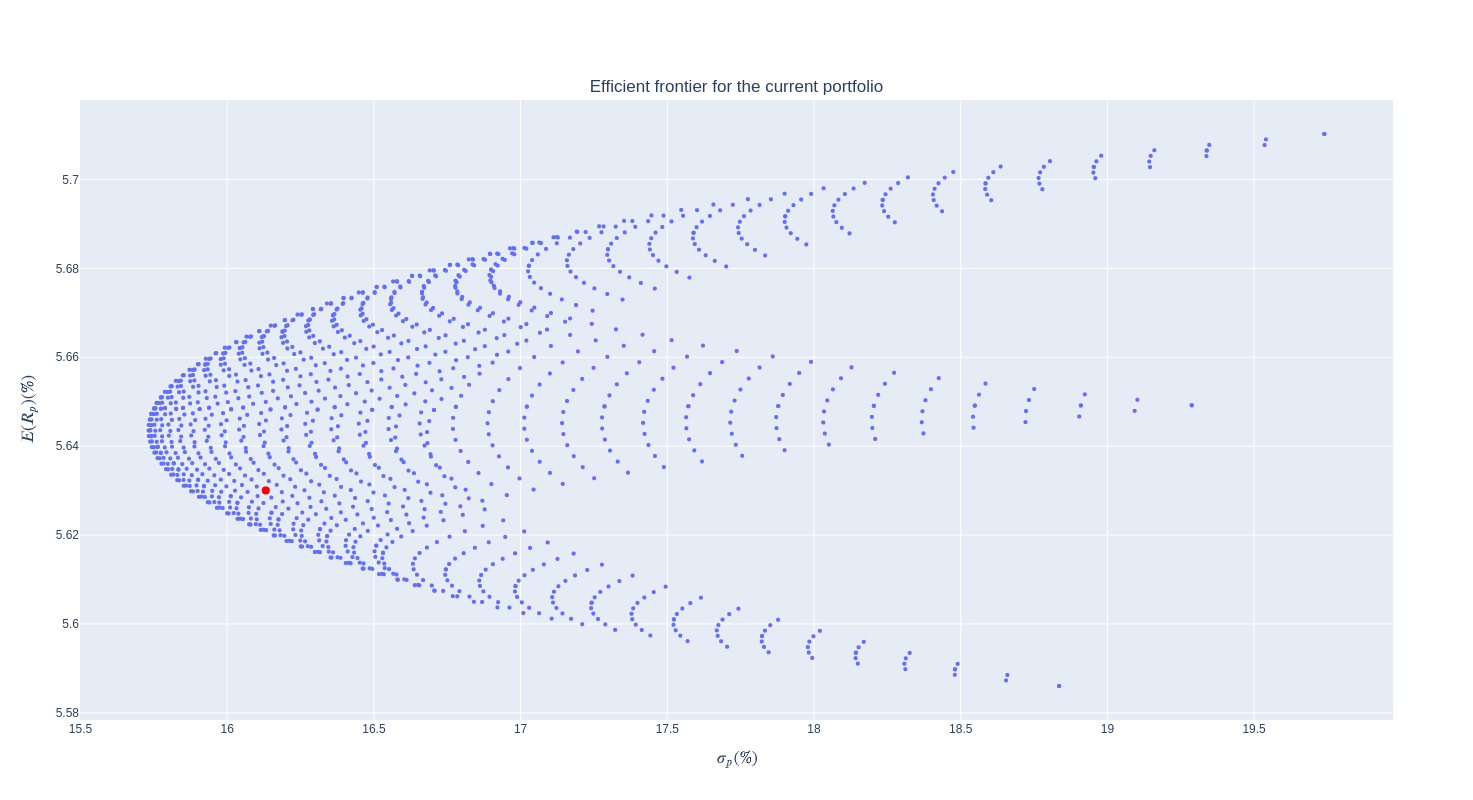

In [19]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=100*np.array(portfolio_sd), y=100*np.array(portfolio_returns), mode="markers", marker=dict(size=4)))
fig.add_trace(go.Scatter(x=[100*curr_portfolio_stdev], y=[100*curr_portfolio_return], mode="markers", marker=dict(size=8, color="red")))

fig.update_yaxes(title_text="$E(R_p) (\%)$")
fig.update_xaxes(title_text="$\\sigma_p (\%)$")
fig.update_layout(title_text="Efficient frontier for the current portfolio", 
                  title_x=0.5,
                  title_y=0.9,
                  height=800,
                  showlegend=False
                 )
fig.show()

**The red dot above indicates where our current portfolio sits with respect to the efficient frontier. But can we improve on this for better risk-adjusted returns?**

# IV. Optimal Risky Portfolio

The optimal portfolio in Modern Portfolio Theory is characterised by two main properties:
1. The risk-adjusted returns are maximised.
2. The Capital Allocation Line is tangent to the efficient frontier at this point.

Clearly, we need to use the first bullet to identify the optimal portfolio, as we don't have our CAL yet. 

In [20]:
risk_return_df = pd.DataFrame({"sigma_p": np.round(portfolio_sd, 4), "er_p": np.round(portfolio_returns, 4)})
ticker_weights_df = pd.DataFrame.from_records(ticker_weights, columns=ticker_list)
risk_return_df = pd.concat([risk_return_df, ticker_weights_df], axis=1)

In [21]:
avg_rf = ten_yr_yield["yield"].mean()

In [22]:
risk_adj_returns = (risk_return_df["er_p"] - 0.016)/(risk_return_df["sigma_p"])
optimal_portfolio = risk_return_df.iloc[risk_adj_returns.idxmax()]

In [23]:
optimal_portfolio

sigma_p    0.1574
er_p       0.0565
AAPL       0.3400
GOOG       0.3000
MSFT       0.3600
Name: 1388, dtype: float64

In [24]:
opt_portfolio_stats = optimal_portfolio.to_dict()

In [25]:
opt_return = np.round(optimal_portfolio.loc["er_p"], 2)
opt_sdev = np.round(optimal_portfolio.loc["sigma_p"], 2)

print(f"So, our optimal portfolio of stocks (after analysing {period} of data) for {ticker_list} has the following weights: {list(optimal_portfolio.loc[ticker_list].values)}.")
print(f"This portfolio has a return of {opt_return*100}% and standard deviation of returns equal to {opt_sdev*100}%.")

So, our optimal portfolio of stocks (after analysing 1y of data) for ['AAPL', 'GOOG', 'MSFT'] has the following weights: [0.34, 0.3, 0.36].
This portfolio has a return of 6.0% and standard deviation of returns equal to 16.0%.


# V. Capital Allocation Line (CAL)
$E(R_p) = R_f+\frac{E(R_i) - R_f}{\sigma_i}*\sigma_p$

where:
- $E(R_p)$ is the expected return of the portfolio (the dependent variable)
- $R_f$ is the risk free rate of return
- $\sigma_p$ is the standard deviation of portfolio returns (the independent variable)
- $\sigma_i$ and $E(R_i)$ are the standard deviation and expected returns for a portfolio on the CAL.

We know that our CAL passes through the y intercept $(0, R_f)$ and the optimal portfolio point $(\sigma_{opt}, E(R_{opt})$. So, we can use this to get the equation for our CAL. 

In [26]:
x_cal = np.arange(0, max(portfolio_sd), 0.01)
y_cal = avg_rf + (optimal_portfolio.loc["er_p"] - avg_rf)/(optimal_portfolio.loc["sigma_p"])*x_cal

In [27]:
opt_portfolio_stats["rf"] = avg_rf
opt_portfolio_stats["sharpe_ratio"] = (optimal_portfolio.loc["er_p"] - avg_rf)/(optimal_portfolio.loc["sigma_p"])

In [28]:
cal = pd.DataFrame({"x": x_cal, "y": y_cal})

mask = (cal["y"] < max(portfolio_returns)+0.005) & (cal["y"] > min(portfolio_returns)-0.005)
cal = cal.loc[mask]

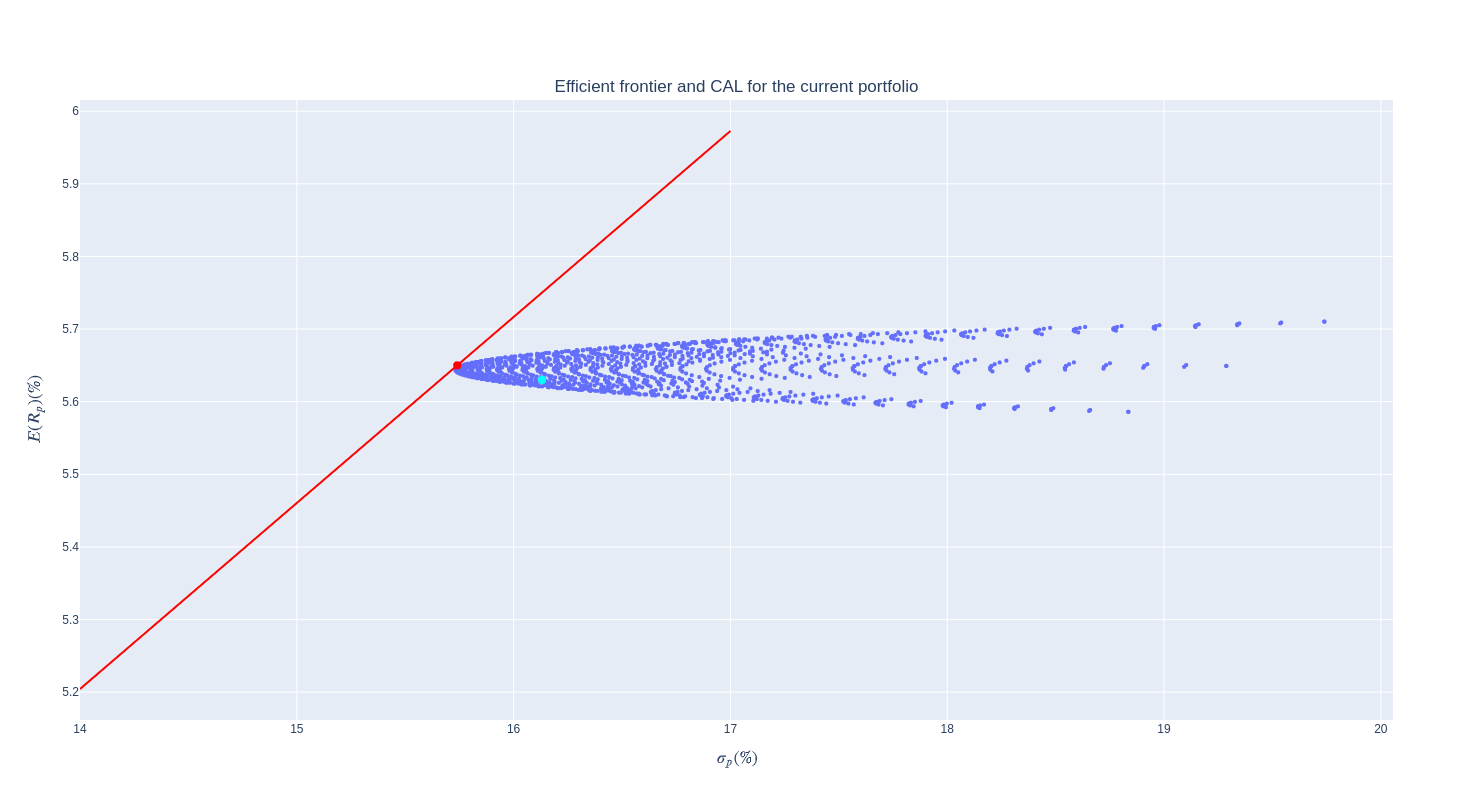

In [29]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=100*np.array(portfolio_sd), y=100*np.array(portfolio_returns), mode="markers", marker=dict(size=4)))

fig.add_trace(go.Scatter(x=100*cal["x"], y=100*cal["y"], line = dict(color='red', width=2), mode='lines'))

fig.add_trace(go.Scatter(x=[100*optimal_portfolio.loc["sigma_p"]], y=[100*optimal_portfolio.loc["er_p"]], marker=dict(size=8, color="red")))

fig.add_trace(go.Scatter(x=[100*curr_portfolio_stdev], y=[100*curr_portfolio_return], marker=dict(size=8, color="cyan")))

fig.update_yaxes(title_text="$E(R_p) (\%)$")
fig.update_xaxes(title_text="$\\sigma_p (\%)$")
fig.update_layout(title_text="Efficient frontier and CAL for the current portfolio", 
                  title_x=0.5,
                  title_y=0.9,
                  height=800,
                  showlegend=False
                 )
fig.show()

# VI. Optimal Utility Curves

The investor's utility function can be modelled as: $U = E(r)-\frac{1}{2}*A*\sigma^2$, where:
- $E(r)$ is the expected return
- $\sigma$ is the std. dev of the portfolio's returns
- $U$ is the investor's Utility
- $A$ is the investor's risk-aversion coefficient. 

The risk-aversion coefficient is typically estimated for each investor based on the investor's risk preferences. From information the investor provides, we can solve some equations behind the scenes to model utility as a function of wealth. The coefficient $A$ is then determined as $-\frac{U''(W)}{U'(W)}$. But for our purposes, we can simplify the calculation by using literature that states that the value of $A$ usually lies between 1 and 3: https://files.stlouisfed.org/files/htdocs/wp/2014/2014-005.pdf. 

We know that the most optimal investor portfolio is one that is tangent to the CAL line. This means that the expected return can be modelled using the Sharpe ratio: $E = s*\sigma_p + R_f$. But there can be infinite utility curves that are tangent to the CAL line, so which one is best? Well, it is the curve that maximises utility. 

Substituting our equation for E in the utility function above:
$$U = s*\sigma + R_f - 0.5*A*\sigma^2$$

Maximising an inverse quadratic function means finding the point at which the derivative equals 0:

$$U'(\sigma) = s-A*\sigma = 0$$
$$\sigma_{opt} = \frac{s}{A}$$

With that, we can compute our max utility $U$:
$$U_{max}=s*\sigma_{opt} + R_f - 0.5*A*\sigma_{opt}^2 = 0.5*\frac{s^2}{A}+R_f$$

Finally, we can plot our optimal utility curve as:
$$E = U_{max}+0.5*A*\sigma_p^2$$

In [30]:
def expected_return_cal(portfolio_stats: dict, sigma_p: np.array):
    return portfolio_stats["rf"] + portfolio_stats["sharpe_ratio"]*sigma_p

In [31]:
def compute_max_utility_stats(portfolio_stats: dict, A: int) -> float:
    sharpe = portfolio_stats["sharpe_ratio"]
    rf = portfolio_stats["rf"]
    U_max = 0.5*(sharpe**2)/A + rf
    
    return U_max

In [32]:
def get_optimal_investor_portfolio(portfolio_stats: dict, A: int) -> Union[float, float]:
    sharpe = portfolio_stats["sharpe_ratio"]
    rf = portfolio_stats["rf"]
    sigma_opt = sharpe/A
    erp_opt = expected_return_cal(portfolio_stats, np.array([sigma_opt]))
    
    return erp_opt[0], sigma_opt

In [33]:
def generate_points_to_plot_indifference_curve(portfolio_stats: dict, A: int, portfolio_sd: Iterable) -> pd.DataFrame:
    U_max = compute_max_utility_stats(portfolio_stats, A)
    _, sigma_opt = get_optimal_investor_portfolio(portfolio_stats, A)
    
    sd_of_portfolio_sd = np.std(portfolio_sd)
    x = np.arange(sigma_opt - 3*sd_of_portfolio_sd, sigma_opt + 3*sd_of_portfolio_sd, 0.01)
    y = U_max + 0.5*A*(x**2)
    
    return pd.DataFrame({"x": x, "y": y})

In [34]:
list_of_possible_A = [1,2,3]

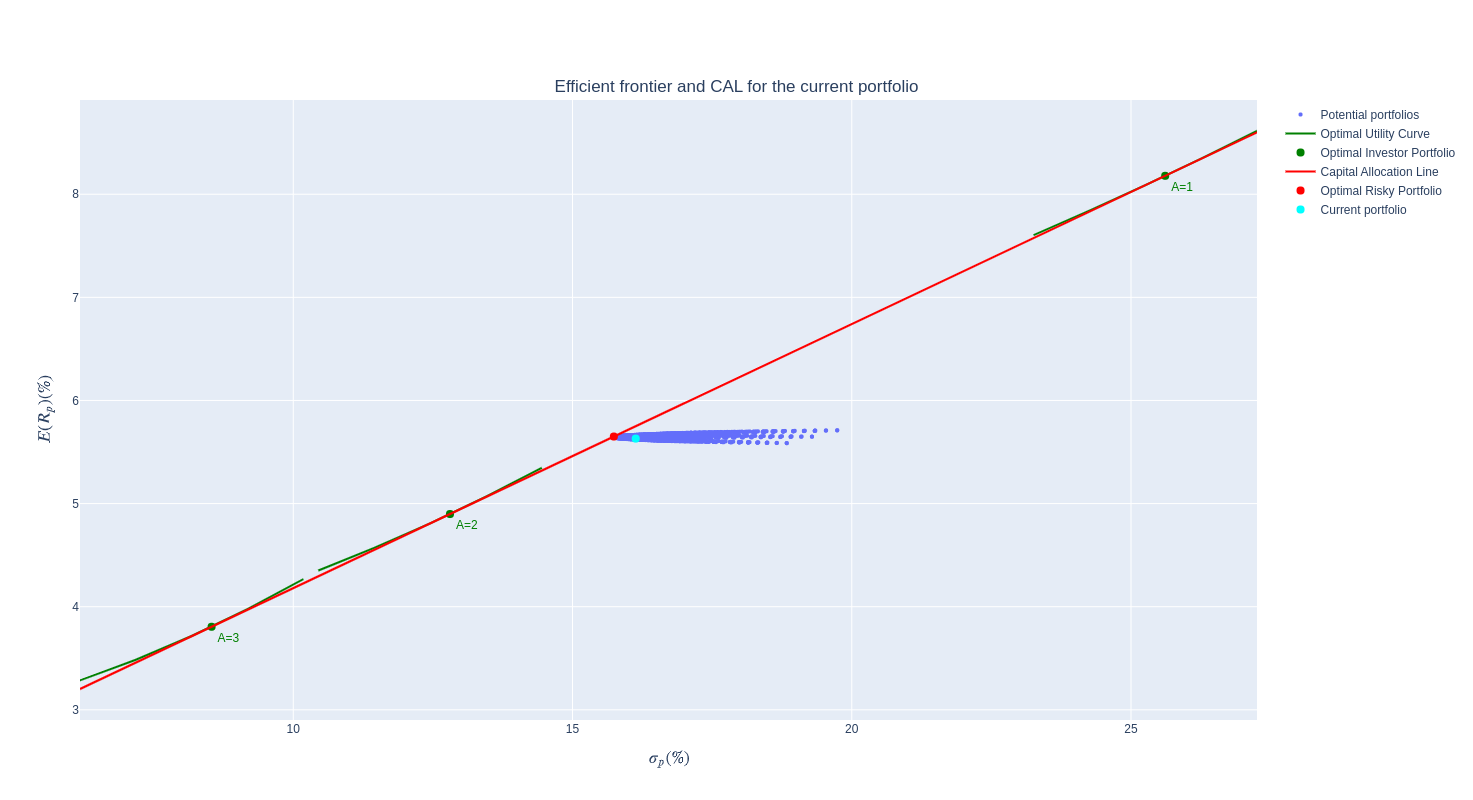

In [35]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=100*np.array(portfolio_sd), y=100*np.array(portfolio_returns), mode="markers", marker=dict(size=4), name='Potential portfolios'))
cal_x = []

for A in list_of_possible_A:
    indiff_curve_df = generate_points_to_plot_indifference_curve(opt_portfolio_stats, A, portfolio_sd)
    if A == list_of_possible_A[0]:
        curve_name = 'Optimal Utility Curve'
        dot_name = 'Optimal Investor Portfolio'
    else: 
        curve_name = 'null'
        dot_name = 'null'

    fig.add_trace(go.Scatter(x=100*indiff_curve_df["x"], y=100*indiff_curve_df["y"], line = dict(color='green', width=2), mode="lines", name=curve_name))
    erp_opt, sigma_opt = get_optimal_investor_portfolio(opt_portfolio_stats, A)
    fig.add_trace(go.Scatter(x=[100*sigma_opt], y=[100*erp_opt], marker=dict(size=8, color="green"), mode="markers+text", name=dot_name, text=[f'A={A}'], textposition="bottom right", textfont=dict(color="green")))

    cal_x += list(indiff_curve_df["x"])

cal_x = np.array(cal_x + list(cal["x"]))
cal_y = expected_return_cal(opt_portfolio_stats, cal_x)
fig.add_trace(go.Scatter(x=100*cal_x, y=100*cal_y, line = dict(color='red', width=2), mode='lines', name='Capital Allocation Line'))

fig.add_trace(go.Scatter(x=[100*optimal_portfolio.loc["sigma_p"]], y=[100*optimal_portfolio.loc["er_p"]], mode="markers", marker=dict(size=8, color="red"), name='Optimal Risky Portfolio'))

fig.add_trace(go.Scatter(x=[100*curr_portfolio_stdev], y=[100*curr_portfolio_return], marker=dict(size=8, color="cyan"), mode="markers", name='Current portfolio'))

for trace in fig['data']: 
    if(trace['name'] == 'null'): 
        trace['showlegend'] = False
    
fig.update_yaxes(title_text="$E(R_p) (\%)$")
fig.update_xaxes(title_text="$\\sigma_p (\%)$")
fig.update_layout(title_text="Efficient frontier and CAL for the current portfolio", 
                  title_x=0.5,
                  title_y=0.9,
                  height=800,
                  showlegend=True
                 )
fig.show()

# VII. Portfolio beta

In [36]:
portfolio_beta = 0

for ticker in ticker_list:
    portfolio_beta += opt_portfolio_stats[ticker]*stock_to_beta.loc[ticker]["beta"]

opt_portfolio_stats["beta_p"] = portfolio_beta

**Treynor ratio:**

$TR = \frac{E(R_p)-R_f}{\beta_p}$

In [37]:
opt_portfolio_stats["treynor_ratio"] = (opt_portfolio_stats["er_p"] - opt_portfolio_stats["rf"])/(opt_portfolio_stats["beta_p"])

# VIII. Risk adjusted performance

In [38]:
er_market = np.product(1+df["sp500_daily_returns"]) - 1
sigma_market = np.std(df["sp500_daily_returns"])*ann_std_multiplier
beta_market = 1

In [39]:
max_sigma = max(sigma_market, opt_portfolio_stats["sigma_p"])
rf = opt_portfolio_stats["rf"]

x = np.arange(0, max_sigma+0.1, 0.01)

sharpe_market = (er_market - rf)/(sigma_market)
y_cml = rf + sharpe_market*x

y_p = rf + opt_portfolio_stats["sharpe_ratio"]*x

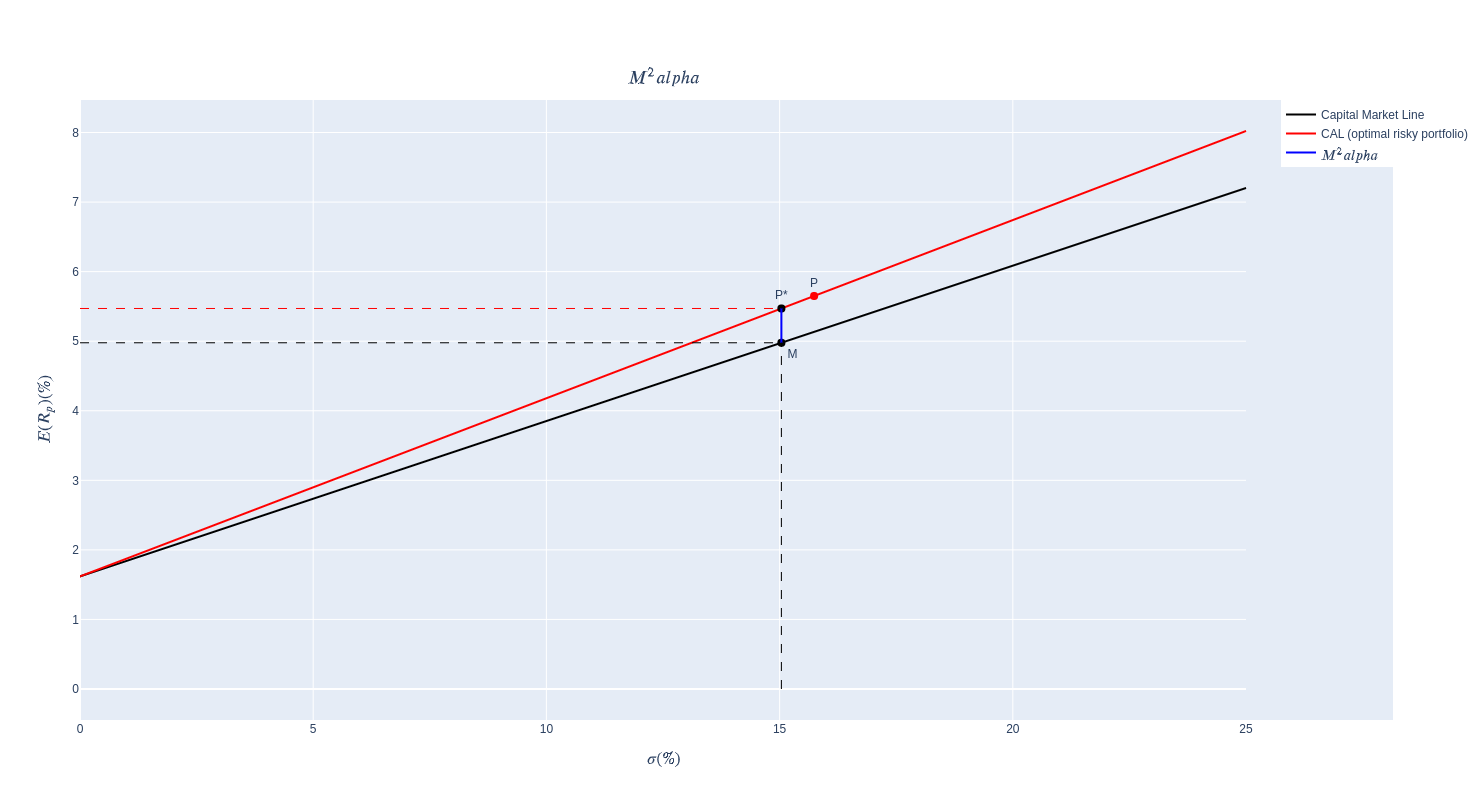

In [40]:
fig = go.Figure()
if sharpe_market < opt_portfolio_stats["sharpe_ratio"]:
    market_textpos = "bottom right"
    p_textpos = "top center"
else:
    market_textpos = "top center"
    p_textpos = "bottom right"

fig.add_trace(go.Scatter(x=100*x, y=100*y_cml, mode="lines", line = dict(color='black', width=2), name="Capital Market Line"))
fig.add_trace(go.Scatter(x=[100*sigma_market], y=[100*er_market], marker=dict(size=8, color="black"), mode="markers+text", text="M", name="null", textposition=market_textpos))

fig.add_trace(go.Scatter(x=100*x, y=100*y_p,  mode='lines', line = dict(color='red', width=2), name="CAL (optimal risky portfolio)"))
fig.add_trace(go.Scatter(x=[100*opt_portfolio_stats["sigma_p"]], y=[100*opt_portfolio_stats["er_p"]], marker=dict(size=8, color="red"), mode="markers+text", text="P", name="null", textposition=p_textpos))

p_star = rf + opt_portfolio_stats["sharpe_ratio"]*sigma_market
fig.add_trace(go.Scatter(x=[100*sigma_market], y=[100*p_star], marker=dict(size=8, color="black"), mode="markers+text", text="P*", name="null", textposition=p_textpos))

m2alpha_y = np.linspace(er_market, p_star, 5)
m2alpha_x = np.ones(5)*sigma_market
fig.add_trace(go.Scatter(x=100*m2alpha_x, y=100*m2alpha_y,  mode='lines', line = dict(color='blue', width=2), name="$M^2 alpha$"))

misc_x = np.arange(0, sigma_market, 0.01)
misc_y1 = np.ones(len(misc_x))*p_star
misc_y2 = np.ones(len(misc_x))*er_market

misc_y3 = np.linspace(0, min(p_star, er_market), 50)
misc_x3 = np.ones(len(misc_y3))*sigma_market

fig.add_trace(go.Scatter(x=100*misc_x, y=100*misc_y1, mode="lines", line = dict(color='red', width=1, dash="dash"), name="null"))
fig.add_trace(go.Scatter(x=100*misc_x, y=100*misc_y2, mode="lines", line = dict(color='black', width=1, dash="dash"), name="null"))
fig.add_trace(go.Scatter(x=100*misc_x3, y=100*misc_y3, mode="lines", line = dict(color='black', width=1, dash="dash"), name="null"))

for trace in fig['data']: 
    if(trace['name'] == 'null'):
        trace['showlegend'] = False

fig.update_yaxes(title_text="$E(R_p) (\%)$")
fig.update_xaxes(title_text="$\\sigma (\%)$")
fig.update_layout(title_text="$M^2 alpha$", 
                  title_x=0.45,
                  title_y=0.9,
                  height=800,
                  showlegend=True
                 )
fig.show()

In [41]:
max_sigma = max(sigma_market, opt_portfolio_stats["sigma_p"])
rf = opt_portfolio_stats["rf"]

x = np.arange(0, max(beta_market, opt_portfolio_stats["beta_p"])+1, 0.1)

sml_slope = (er_market - rf)/(beta_market)
y_sml = rf + sml_slope*x

y_p = rf + opt_portfolio_stats["treynor_ratio"]*x

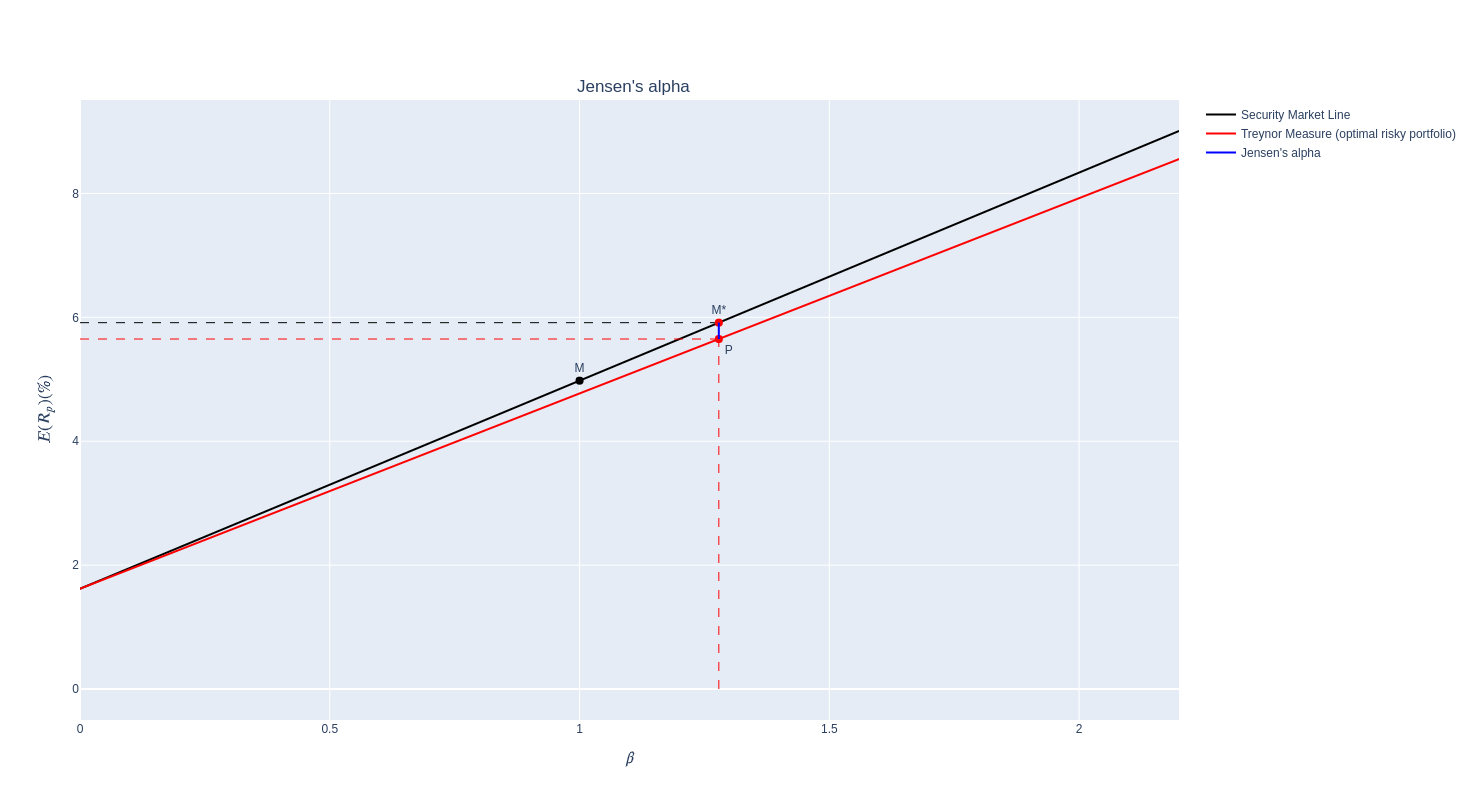

In [42]:
fig = go.Figure()
if sml_slope < opt_portfolio_stats["treynor_ratio"]:
    market_textpos = "bottom right"
    p_textpos = "top center"
else:
    market_textpos = "top center"
    p_textpos = "bottom right"

fig.add_trace(go.Scatter(x=x, y=100*y_sml, mode="lines", line = dict(color='black', width=2), name="Security Market Line"))
fig.add_trace(go.Scatter(x=[beta_market], y=[100*er_market], marker=dict(size=8, color="black"), mode="markers+text", text="M", name="null", textposition=market_textpos))

fig.add_trace(go.Scatter(x=x, y=100*y_p,  mode='lines', line = dict(color='red', width=2), name="Treynor Measure (optimal risky portfolio)"))
fig.add_trace(go.Scatter(x=[opt_portfolio_stats["beta_p"]], y=[100*opt_portfolio_stats["er_p"]], marker=dict(size=8, color="red"), mode="markers+text", text="P", name="null", textposition=p_textpos))

m_star = rf + sml_slope*opt_portfolio_stats["beta_p"]
fig.add_trace(go.Scatter(x=[opt_portfolio_stats["beta_p"]], y=[100*m_star], marker=dict(size=8, color="red"), mode="markers+text", text="M*", name="null", textposition=market_textpos))

jalpha_y = np.linspace(opt_portfolio_stats["er_p"], m_star, 5)
jalpha_x = np.ones(5)*opt_portfolio_stats["beta_p"]
fig.add_trace(go.Scatter(x=jalpha_x, y=100*jalpha_y,  mode='lines', line = dict(color='blue', width=2), name="Jensen's alpha"))

misc_x = np.arange(0, opt_portfolio_stats["beta_p"], 0.01)
misc_y1 = np.ones(len(misc_x))*m_star
misc_y2 = np.ones(len(misc_x))*opt_portfolio_stats["er_p"]

misc_y3 = np.linspace(0, min(m_star, opt_portfolio_stats["er_p"]), 50)
misc_x3 = np.ones(len(misc_y3))*opt_portfolio_stats["beta_p"]

fig.add_trace(go.Scatter(x=misc_x, y=100*misc_y1, mode="lines", line = dict(color='black', width=1, dash="dash"), name="null"))
fig.add_trace(go.Scatter(x=misc_x, y=100*misc_y2, mode="lines", line = dict(color='red', width=1, dash="dash"), name="null"))
fig.add_trace(go.Scatter(x=misc_x3, y=100*misc_y3, mode="lines", line = dict(color='red', width=1, dash="dash"), name="null"))

for trace in fig['data']: 
    if(trace['name'] == 'null'):
        trace['showlegend'] = False

fig.update_yaxes(title_text="$E(R_p) (\%)$")
fig.update_xaxes(title_text="$\\beta$")
fig.update_layout(title_text="Jensen's alpha", 
                  title_x=0.43,
                  title_y=0.9,
                  height=800,
                  showlegend=True
                 )
fig.show()

In [43]:
opt_portfolio_stats["m2_alpha"] = p_star - er_market
opt_portfolio_stats["jensens_alpha"] = opt_portfolio_stats["er_p"] - m_star

# IX. Value at Risk (VaR)

# X. Optimal Portfolio Stats

In [44]:
opt_portfolio_stats["sigma_p_percent"] = opt_portfolio_stats.pop("sigma_p")
opt_portfolio_stats["sigma_p_percent"] = 100*opt_portfolio_stats["sigma_p_percent"]

opt_portfolio_stats["expected_return_percent"] = opt_portfolio_stats.pop("er_p")
opt_portfolio_stats["expected_return_percent"] = 100*opt_portfolio_stats["expected_return_percent"]

opt_portfolio_stats["avg_risk_free_rate"] = opt_portfolio_stats.pop("rf")
opt_portfolio_stats["avg_risk_free_rate"] = 100*opt_portfolio_stats["avg_risk_free_rate"]

In [45]:
for ticker in ticker_list:
    opt_portfolio_stats[f"weight_{ticker}"] = opt_portfolio_stats.pop(ticker)

In [46]:
final_stats = pd.DataFrame(opt_portfolio_stats, index=[0]).transpose().rename(columns={0: "optimal_risky_portfolio_stats"})

final_stats

optimal_risky_portfolio_stats
sharpe_ratio                                  0.256123
beta_p                                        1.278800
treynor_ratio                                 0.031525
m2_alpha                                      0.004929
jensens_alpha                                -0.002638
sigma_p_percent                              15.740000
expected_return_percent                       5.650000
avg_risk_free_rate                            1.618617
weight_AAPL                                   0.340000
weight_GOOG                                   0.300000
weight_MSFT                                   0.360000